<a style="float:left;" href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Couverture_Terrestre/ImagesSatellitaires-AnalyseCouvertureTerrestre.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<br/>
### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter);
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables;
* Pour obtenir de l'information sur une fonction, utilisez la commande Python `help(`"nom de la fonction"`)`

# Images satellitaires - Analyse de la couverture terrestre

## Utilisation d'un réseau convolutif

Ce carnet IPython pour Google Colab est une traduction et une adaptation du tutoriel « <a href="https://github.com/patrickcgray/open-geo-tutorial/blob/master/notebooks/chapter_6_neural_networks.ipynb" target='_blank'>Chapter 6: Using Neural Networks for Classification and Land Cover Mapping</a> » de <a href="https://github.com/patrickcgray" target='_blank'><b>Patrick Gray</b></a> par <a href="https:/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Couverture_Terrestre/ImagesSatellitaires-AnalyseCouvertureTerrestre.ipynb" target='_blank'>Claude Coulombe</a>. 

## Introduction

L'apprentissage profond est à la fois surexposé sur le plan médiatique et sous-utilisé en pratique (https://doi.org/10.1038/nature14539). Peu importe,  l'apprentissage profond constitue un puissant coffre à outils pour analyser d'énormes quantités de données. De nouvelles applications passionnantes se développent rapidement en <a href="https://doi.org/10.1109/MGRS.2017.2762307" target='_blank'>télédétection</a> dans des domaines tels que la <a href="https://doi.org/10.1109/TGRS.2018.2872509" target='_blank'>détection d'anomalies</a>, la <a href="https://doi.org/10.1109/TGRS.2016.2612821" target='_blank'>classification des images</a> et la <a href="https://doi.org/10.3390/rs11070768" target='_blank'>régression des variables biophysiques</a>. 

Vous expérimenterez ici un exemple simple de classification de la couverture terrestre à partir d'images satellitaires de <i>Landsat 8</i> du <i>National Landcover Dataset</i> américain comme données d'entraînement et d'un réseau convolutif profond.

Lancé par la <i>NASA</i> au début des années 1970, <i>Landsat</i> est un programme d’observation de la terre basé sur une constellation de 8 satellites.  <i>Landsat</i> est destiné à des applications civiles (agriculture, utilisation des sols, foresterie, urbanisme, etc.)

## Plan

*   Installation de bibiothèques Python requises;
*   Téléchargement des données depuis GitHub;
*   Création de fonctions utilitaires;
*   Exploration des données;
*   Création d'une base de référence
    * pour la classification avec l'algorithme des K-plus-proches-voisins (<i>K nearest neighbors</i>)
    * l'algorithme de la forêt aléatoire (<i>random forest</i>);
*   Création et entraînement d'un réseau convolutif;
*   Évaluation et comparaison du modèle.

## Installation de bibliothèques Python

In [1]:
# Installation de bibliothèques Python
! pip3 install geopandas rasterio matplotlib descartes scikit-learn

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


## Fixer le hasard pour la reproductibilité

La mise au point de réseaux de neurones implique certains processus aléatoires. Afin de pouvoir reproduire et comparer vos résultats d'expérience, vous fixez temporairement l'état aléatoire grâce à un germe aléatoire unique.

Pendant la mise au point, vous fixez temporairement l'état aléatoire pour la reproductibilité mais vous répétez l'expérience avec différents germes ou états aléatoires et prenez la moyenne des résultats.
<br/>
##### **Note**: Pour un système en production, vous ravivez simplement l'état  purement aléatoire avec l'instruction `GERME_ALEATOIRE = None`

In [2]:
import os

# Définir un germe aléatoire
GERME_ALEATOIRE = 21

# Définir un état aléatoire pour Python
os.environ['PYTHONHASHSEED'] = str(GERME_ALEATOIRE)

# Définir un état aléatoire pour Python random
import random
random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour NumPy
import numpy as np
np.random.seed(GERME_ALEATOIRE)

# Définir un état aléatoire pour TensorFlow
import tensorflow as tf
tf.random.set_seed(GERME_ALEATOIRE)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

print("Germe aléatoire fixé")

Germe aléatoire fixé


## Téléchargement des données depuis GitHub

In [89]:
!wget https://github.com/ClaudeCoulombe/open-geo-tutorial/blob/master/data.zip?raw=True -O data.zip


zsh:1: no matches found: https://github.com/ClaudeCoulombe/open-geo-tutorial/blob/master/data.zip?raw=True


### Décompression des données

In [4]:
import os
import zipfile

zip_ref = zipfile.ZipFile('data.zip','r')
zip_ref.extractall('.')
zip_ref.close()


In [5]:
!ls -all data

total 195448
drwxr-xr-x  22 claudecoulombe  staff       704  5 Jan 21:54 .
drwxr-xr-x   9 claudecoulombe  staff       288 13 Jan 10:51 ..
-rw-r--r--   1 claudecoulombe  staff   1003162 13 Jan 10:54 LE70220491999322EDC01_stack.gtif
-rw-r--r--   1 claudecoulombe  staff      3011 13 Jan 10:54 LE70220491999322EDC01_stack.gtif.aux.xml
-rw-r--r--   1 claudecoulombe  staff   1002492 13 Jan 10:54 LE70220492002106EDC00_stack.gtif
-rw-r--r--   1 claudecoulombe  staff   1743350 13 Jan 10:54 RGB.byte.tif
-rw-r--r--   1 claudecoulombe  staff   1711850 13 Jan 10:54 RGB2.byte.tif
-rw-r--r--   1 claudecoulombe  staff    145989 13 Jan 10:54 dask-overview.svg
-rw-r--r--   1 claudecoulombe  staff     56103 13 Jan 10:54 dataset-diagram.png
-rw-r--r--   1 claudecoulombe  staff    716577 13 Jan 10:54 folium_exp.png
-rw-r--r--   1 claudecoulombe  staff   9805175 13 Jan 10:54 gulfstreamStackedSST.tif
-rw-r--r--   1 claudecoulombe  staff   6157764 13 Jan 10:54 hatterasGulfStackedSST.tif
-rw-r--r--   1 claudeco

### Les différentes classes de couverture du sol

In [6]:
# Dictionnaire de toutes les classes et de leur identifiant
classes_couverture = dict((
    (0,  "arrière-plan"), # (0,  'Background'),
    (1,  "non-classé"), # (1, 'Unclassified'),
    # anthropoformé ou aménagé ?
    (2,  "fortement aménagé"), # (2, 'High Intensity Developed'),
    (3,  "moyennement aménagé"), # (3, 'Medium Intensity Developed'),
    (4,  "faiblement aménagé"), # (4, 'Low Intensity Developed'),
    (5,  "espace ouvert aménagé"),# (5, 'Open Space Developed'),
    (6,  "terre cultivée"), # (6, 'Cultivated Land'),
    (7,  "pâturage/foin"), # (7, 'Pasture/Hay')
    (8,  "prairie"), # (8, 'Grassland'),
    (9,  "forêt de feuillus"), # (9, 'Deciduous Forest'),
    (10, "forêt de conifères"), # (10, 'Evergreen Forest'),
    (11, "forêt mixte"), # (11, 'Mixed Forest'),
    (12, "arbuste/broussaille"), # (12, 'Scrub/Shrub'),
    (13, "milieu humide boisé palustre"), # (13, 'Palustrine Forested Wetland'),
    (14, "milieu humide arbustif/broussailleux palustre"), # (14, 'Palustrine Scrub/Shrub Wetland'),
    (15, "milieu humide émergent palustre"), # (15, 'Palustrine Emergent Wetland'),
    (16, "milieu humide boisé estuarien"), # (16, 'Estuarine Forested Wetland'),
    (17, "milieu humide arbustif/broussailleux estuarien"), # (17, 'Estuarine Scrub/Shrub Wetland')
    (18, "milieu humide émergent estuarien"), # (18, 'Estuarine Emergent Wetland'),
    (19, "rivage meuble/non consolidé"), # (19, 'Unconsolidated Shore'),
    (20, "terre nue"), # (20, 'Bare Land'),
    (21, "eau"), # (21, 'Water'),
    (22, "lit de cours d'eau palustre"), # (22, 'Palustrine Aquatic Bed'),
    (23, "lit de cours d'eau estuarien"), # (23, 'Estuarine Aquatic Bed'),
    (24, 'toundra'), # (24, 'Tundra'),
    (25, 'neige/glace') # (25, 'Snow/Ice')
))

print('Code exécuté!')


Code exécuté!


## Création de fonctions utilitaires

### Un générateur de pixels aléatoires 

Générateur de pixels aléatoires définis par leurs positions x, y dans une image. Le générateur tient compte des tailles différentes des classes-cibles et fournit un ensemble de données d'entraînement équilibré.

Cette fonction extrait un nombre nbre_donnees_entrainement + nbre_donnees_validation de pixels aléatoires d'une liste de jeux de données matricielles (<i>raster</i>) fournie en entrée. Elle retourne une liste de positions de pixels d'entraînement associée à une image (index_image) et une liste de positions de pixels de validation également avec un index d'image.

In [7]:
import math
import random
import itertools

from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
import rasterio.features
import rasterio.warp
import rasterio.mask

from pyproj import Proj, transform
from tqdm import tqdm
from shapely.geometry import Polygon

def generer_pixels(liste_jeux_donnees_images,
                   label_dataset,
                   etiquettes_couverture,
                   classes_couverture,
                   train_count,
                   merge=False):
    
    # Rappel: système de référence géodésique, en anglais "Coordinate Reference System" (CRS)
    # Obtenir le système de projection cartographique des étiquettes de classe-cible 
    projection_cartographique_etiquettes = Proj(label_dataset.crs)  
    # initialiser le jeu de pixel d'entraînement
    pixels_entrainement = []
    nbr_donnees_entrainement_par_jeu = math.ceil(train_count / len(liste_jeux_donnees_images))
    print("Nombre de donnees d'entraînement par jeu de données:",nbr_donnees_entrainement_par_jeu)
    print("Nombre d'images dans le jeu de données:",len(liste_jeux_donnees_images))
    for index, jeu_donnees_images in enumerate(liste_jeux_donnees_images):
        # Combien de points de données pour chaque classe-cible?
        points_par_classe = nbr_donnees_entrainement_par_jeu // len(np.unique(fusionner_classes(etiquettes_couverture,classes_couverture)[0]))
        print("Nombre de points de données par classe-cible:",points_par_classe)
        # obtenir les limites (4 coins) de l'image Landsat
        # créer un masque approximatif pour le jeu de données dans les coordonnées géographiques
        # create approx dataset mask in geographic coords
        # this fcn maps pixel locations in (row, col) coordinates to (x, y) spatial positions
        raster_points = jeu_donnees_images.transform * (0, 0), jeu_donnees_images.transform * (jeu_donnees_images.width, 0), jeu_donnees_images.transform * (jeu_donnees_images.width, jeu_donnees_images.height), jeu_donnees_images.transform * (0, jeu_donnees_images.height)
        print("raster_points:",raster_points)
        l8_proj = Proj(jeu_donnees_images.crs)
        new_raster_points = []
        # convert the raster bounds from landsat into label crs
        for x,y in raster_points:
            x,y = transform(l8_proj,projection_cartographique_etiquettes,x,y)
            # convert from crs into row, col in label image coords
            row, col = label_dataset.index(x, y)
            # don't forget row, col is actually y, x so need to swap it when we append
            new_raster_points.append((col, row))
        # turn this into a polygon
        raster_poly = Polygon(new_raster_points)
        # Window.from_slices((row_start, row_stop), (col_start, col_stop))
        masked_label_image = label_dataset.read(window=Window.from_slices((int(raster_poly.bounds[1]), int(raster_poly.bounds[3])), (int(raster_poly.bounds[0]), int(raster_poly.bounds[2]))))
        if merge:
            masked_label_image = fusionner_classes(masked_label_image,classes_couverture)[0]
        # loop for each class
        all_points_per_image = []
        bar_progression = tqdm(np.unique(fusionner_classes(etiquettes_couverture,classes_couverture)[0]))
        for cls in (bar_progression):
            bar_progression.set_description("Traitement de la classe-cible « %s »" % str(classes_couverture[int(cls)]))
            cls = int(cls)
            # print("cls:",cls,'*'*20)
            # mask the label subset image to each class
            # pull out the indicies where the mask is true
            rows,cols = np.where(masked_label_image[0] == cls)
            all_locations = list(zip(rows,cols))
            # shuffle all locations
            random.shuffle(all_locations)
            # now convert to landsat image crs
            # TODO need to time this to see if it is slow, can probably optimize
            l8_points = []
            # TODO Will probably need to catch this for classes smaller than the ideal points per class
            if len(all_locations)!=0:
                for r,c in all_locations[:points_par_classe]:
                # convert label row and col into label geographic space
                    x,y = label_dataset.xy(r+raster_poly.bounds[1],c+raster_poly.bounds[0])
                # go from label projection into landsat projection
                    x,y = transform(projection_cartographique_etiquettes,l8_proj,x,y)
                # convert from landsat geographic space into row col
                    r,c = jeu_donnees_images.index(x,y)
                    l8_points.append((r,c))
                all_points_per_image += l8_points
        dataset_index_list = [index] * len(all_points_per_image)
        dataset_pixels = list(zip(all_points_per_image, dataset_index_list))
        pixels_entrainement += dataset_pixels
    random.shuffle(pixels_entrainement)
    return (pixels_entrainement)

print('Code generer_pixels prêt!')


Code generer_pixels prêt!


### Un générateur de tuiles de pixels 

Le générateur de tuiles prend des positions de pixels et construit des tuiles de pixels au bon format.

Ce générateur est fourni directement au modèle « keras » et alimente en continu les données du modèle pendant l'entraînement et la validation.


In [61]:
# Générateur de données compatible avec Keras qui génère des tuiles et 
# des étiquettes à la volée à partir d'un ensemble de positions de pixels, 
# d'un jeu de données d'images satellitaires Landsat à 8 canaux d'images 
# et d'un jeu de données d'étiquettes décrivant la couverture terrestre 
def generer_tuiles(jeu_images_Landsat_8canaux, 
                   jeu_etiquettes_couverture, 
                   classes_couverture,
                   hauteur_tuile, largeur_tuile, 
                   positions_pixel, 
                   taille_lot, 
                   merge=False):

    rangee_pixel = 0
    colonne_pixel = 0
    index_pixel = 0
    
    # Proj effectue des transformations cartographiques,
    # convertit la longitude, la latitude en coordonnées 
    # natives x,y de la projection cartographique et vice versa
    label_proj = Proj(jeu_etiquettes_couverture.crs)
    
    # On suppose que toutes les images ont le même nombre de bandes spectrales ou canaux
    compteur_bandes = jeu_images_Landsat_8canaux[0].count 
    # band_count = compteur_bandes
    compteur_classes = len(classes_couverture)
    buffer = math.ceil(hauteur_tuile / 2)
  
    while True:
        # compteur_bandes-1, on enleve une bande parce que nous n'utilisons pas la bande QA
        # qui est la bande de contrôle de la qualité (Quality Assessment) de l'image Landsat
        lot_images = np.zeros((taille_lot, hauteur_tuile, largeur_tuile, compteur_bandes-1)) 
        lot_etiquettes = np.zeros((taille_lot,compteur_classes))
        b = 0
        while b < taille_lot:
            # si nous sommes arrivés à la fin des données, il suffit de recommencer
            if index_pixel >= len(positions_pixel):
                index_pixel = 0
            rangee_pixel, colonne_pixel = positions_pixel[index_pixel][0]
            index_jeu_donnees = positions_pixel[index_pixel][1]
            index_pixel += 1
            tuile = jeu_images_Landsat_8canaux[index_jeu_donnees].read(list(np.arange(1, compteur_bandes+1)), 
                                                              window=Window(colonne_pixel-buffer, 
                                                                            rangee_pixel-buffer, 
                                                                            largeur_tuile, 
                                                                            hauteur_tuile))
            if tuile.size == 0:
                pass
            elif np.amax(tuile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tuile).any() == True or -9999 in tuile: 
                # nous ne voulons pas de tuiles contenant nan ou -999 qui viennent des bordures
                # cela gaspille du temps et est inefficace
                pass
            elif tuile.shape != (compteur_bandes, largeur_tuile, hauteur_tuile):
                #print('mauvaise dimension')
                #print(tuile.shape)
                # tuile aux mauvaises dimensions 
                pass
            elif np.isin(tuile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # le pixel ne doit pas être un nuage
                # cela semble assez inefficace
                # lire: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print("J'ai trouvé un nuage!")
                #print(tuile[7,:,:])
                pass
            else:                
                # retrait de la bande de contrôle de qualité (QA pour Quality Assessment) qui n'est pas utilisée
                tuile = tuile[0:7]
                # reformater du format matriciel (raster) au format d'image normalisé
                tuile_reformatee = (reshape_as_image(tuile)  - 982.5) / 1076.5

                # obtenir l'étiquette de la classe-cible
                # obtenir la géolocalisation du pixel dans l'image
                (x, y) = jeu_images_Landsat_8canaux[index_jeu_donnees].xy(rangee_pixel, colonne_pixel)

                # si la projection cartographique des étiquettes est différente  
                # convertir la localisation du point à partir duquel nous échantillonnons en la même projection que 
                # l'ensemble de données d'étiquettes si nécessaire
                # Rappel: système de référence géodésique - Coordinate Reference System (CRS)
                l8_proj = Proj(jeu_images_Landsat_8canaux[0].crs)
                if l8_proj != label_proj:
                    x,y = transform(l8_proj,label_proj,x,y)

                # reference gps in label_image
                row, col = jeu_etiquettes_couverture.index(x,y)

                # find label
                # label image could be huge so we need this to just get a single position
                window = ((row, row+1), (col, col+1))
                data, classes_couverture = fusionner_classes(jeu_etiquettes_couverture.read(1, 
                                                                                window=window, 
                                                                                masked=False, 
                                                                                boundless=True),
                                                            classes_couverture)
                label = data[0,0]
                # si cette étiquette fait partie d'une couverture non classée alors ignorez la
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:                   
                    # ajouter l'étiquette au lot avec un encodage à un bit discriminant (hot encoding)
                    lot_etiquettes[b][label] = 1
                    lot_images[b] = tuile_reformatee
                    b += 1
        yield (lot_images, lot_etiquettes)

print('Code generer_tuiles prêt!')


Code generer_tuiles prêt!


### Une fonction pour fusionner les classes en un sous-ensemble plus petit

In [62]:
def fusionner_classes(y,classes_couverture):
    
    # reclasser 255 (pixel blanc intense) à 0 (arrière-plan)
    y[y == 255] = 0
    
    # regrouper "moyennement aménagé" 3 et "faiblement aménagé" 4
    # dans "milieu aménagé" 2
    y[y == 3] = 2
    y[y == 4] = 2
    classes_couverture[2] = "milieu aménagé"

    # regrouper "espace ouvert aménagé" 5 et "pâturage/foin" 7
    # dans "terre cultivée" 6
    y[y == 5] = 6
    y[y == 7] = 6
    classes_couverture[6] = "terre cultivée"

    # regrouper "forêt de feuillus" 9 et "forêt de conifères" 10,
    # "arbuste/broussaille" 12, et "milieu humide boisé palustre" 13
    # dans "milieu forestier" 11
    y[y == 9] = 11
    y[y == 10] = 11
    y[y == 12] = 11
    y[y == 13] = 11
    classes_couverture[11] = "milieu forestier"
    
    # regrouper "milieu humide arbustif/broussailleux palustre" 14
    # "milieu humide émergent palustre" 15, "milieu humide boisé estuarien") 16 
    # et "milieu humide arbustif/broussailleux estuarien" 17, 
    # dans "milieu humide" 18
    y[y == 14] = 18
    y[y == 15] = 18
    y[y == 16] = 18
    y[y == 17] = 18
    classes_couverture[18] = "milieu humide"
    
    # regrouper "rivage meuble/non consolidé" 19 et "lit de cours d'eau palustre" 22
    # dans "milieu aquatique" 21
    y[y == 22] = 21
    y[y == 19] = 21
    classes_couverture[21] = "milieu aquatique"
    
    return(y,classes_couverture)

print('Code fusionner_classes prêt!')


Code fusionner_classes prêt!


### Matrice de confusion

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

def afficher_matrice_confusion(y_true, y_pred, classes, class_dict,
                               normalize=False,
                               title=None,
                               cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Matrice de confusion normalisée'
        else:
            title = 'Matrice de confusion sans normalisation'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='Étiquette vraie',
           xlabel='Étiquette prédite')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

print('Code afficher_matrice_confusion prêt!')


Code afficher_matrice_confusion prêt!


## Exploration des données du satellite Landsat

### Lecture des métadonnées sur les images

In [11]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Lecture des métadonnées du fichier de données matricielles (raster) Landsat
meta_donnees_images_landsat = rasterio.open("data/landsat_image.tif")

# Vérification du nombre de canaux / bandes spectrales par image
nombre_canaux = meta_donnees_images_landsat.count
print("Nombre de canaux par image: {nc}\n".format(nc=nombre_canaux))

# Combien de rangées et de colonnes dans les données?
lignes, colonnes = meta_donnees_images_landsat.shape
print("Le format des images est: {l} lignes x {c} colonnes\n".format(l=lignes, c=colonnes))

# Quelle est la version de la bibliothèque Rasterio: 
print("Version de Rasterio: {v}\n".format(v=rasterio.__version__))

# Quel pilote (driver) a été utilisé pour lire les données matricielles (raster)?
pilote = meta_donnees_images_landsat.driver
print("Pilote données matriciel utilisé: {p}\n".format(p=pilote))

# Quelle est la projection géographique des données?
projection_geo = meta_donnees_images_landsat.crs
print("Projection géographique utilisée:\n",projection_geo)


Nombre de canaux par image: 8

Le format des images est: 4475 lignes x 1481 colonnes

Version de Rasterio: 1.2.10

Pilote données matriciel utilisé: GTiff

Projection géographique utilisée:
 PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


###  Lecture et chargement en mémoire des images 
ou données matricielles (raster), images satellitaires Landsat


In [12]:
images_landsat = meta_donnees_images_landsat.read()
images_landsat.shape

(8, 4475, 1481)

### Calcul de l'indice de végétation

Maintenant calculons l'indice de végétation<sup>1</sup>, un indicateur utilisé en télédétection pour évaluer si la cible observée contient de la végétation. L'indice de végétation se calcule à partir des réflectances mesurées dans les bandes visible rouge et le proche infrarouge.
<hr/>
<span style="font-size:80%"><sup>1</sup><b>Note - terminologie:</b> En français,  « indice de végétation par différence normalisée (IVDN) » ou « indice différentiel normalisé de végétation » ou plus simplement « indice de végétation ». En anglais, « <i>Normalized Difference Vegetation Index</i> (<i>NDVI</i>) ».</span>

In [13]:
bande_proche_infrarouge = images_landsat[4, :, :]
bande_rouge = images_landsat[3, :, :]

indice_vegetation = np.clip((bande_proche_infrarouge.astype(float) - bande_rouge.astype(float)) / (bande_proche_infrarouge.astype(float) + bande_rouge.astype(float)), -1,1)

print('Code exécuté!')


Code exécuté!


In [14]:
print('\nIndice de végétation maximum: {m:.2f}'.format(m=indice_vegetation.max()))
print('Indice de végétation moyen: {m:.2f}'.format(m=indice_vegetation.mean()))
print('Indice de végétation médian: {m:.2f}'.format(m=np.median(indice_vegetation)))
print('Indice de végétation minimum: {m:.2f}'.format(m=indice_vegetation.min()))


Indice de végétation maximum: 1.00
Indice de végétation moyen: -0.11
Indice de végétation médian: -0.16
Indice de végétation minimum: -1.00


Examinons la répartition statistique de l'indice de végétation avec un histogramme.

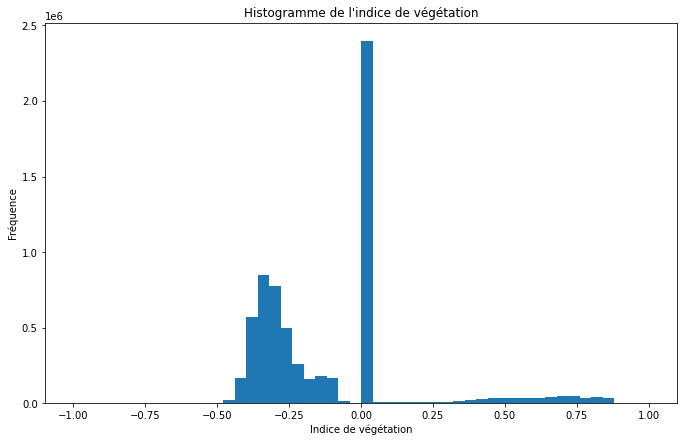

In [15]:
figure, axes = plt.subplots(figsize=(1.62*7,7))
# Nous pouvons définir le nombre de colonnes de l'histogramme avec l'argument `bins`
axes.hist(indice_vegetation.flatten(), bins=50)
plt.title("Histogramme de l'indice de végétation")
plt.xlabel("Indice de végétation")
plt.ylabel("Fréquence")
plt.show()

### Histogramme multicanal de l'image
L'indice de végétation semble normal, regardons maintenant l'histogramme de l'image dans son intégralité.

Qu'est-ce que la valeur numérique (Digital Number, DN)? Dans les systèmes de télédétection, la la valeur numérique est une valeur attribuée à un pixel, généralement sous la forme d'un entier compris entre 0 et 255 (c'est-à-dire un octet). 

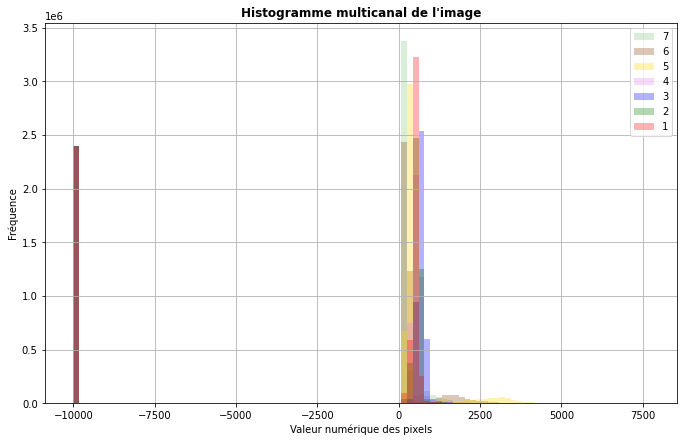

In [16]:
figure, axes = plt.subplots(figsize=(1.62*7,7))

rasterio.plot.show_hist(meta_donnees_images_landsat.read([1,2,3,4,5,6,7]), 
                        bins=100, 
                        histtype='stepfilled', 
                        lw=0.0, 
                        stacked=False, 
                        alpha=0.3,
                        ax = axes,
                       title="Histogramme multicanal de l'image",
                       label=[1,2,3,4,5,6,7]
                       )
axes.set_xlabel('Valeur numérique des pixels')
_ = axes.set_ylabel('Fréquence')


###  Lecture et chargement en mémoire des étiquettes ou annotation de couverture 

In [17]:
meta_donnees_etiquettes_couverture = rasterio.open('data/labels_image.tif')

meta_donnees_etiquettes_couverture.crs

CRS.from_wkt('PROJCS["WGS_1984_Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.256999999996,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [18]:
# nous fusionnons pour limiter le nombre de classes avec lesquelles nous travaillons
etiquettes_couverture, classes_couverture = fusionner_classes(meta_donnees_etiquettes_couverture.read(),classes_couverture)
etiquettes_couverture.shape


(1, 4476, 1482)

### Visualisation - Image Landsat, couverture terrestre et indice de végétation 

Maintenant, nous allons visualiser l'image Landsat, une carte en fausses couleurs des de la couverture terrestre et l'indice de végétation (NDVI) côte à côte :


(3, 4475, 1481)
(4475, 1481, 3)


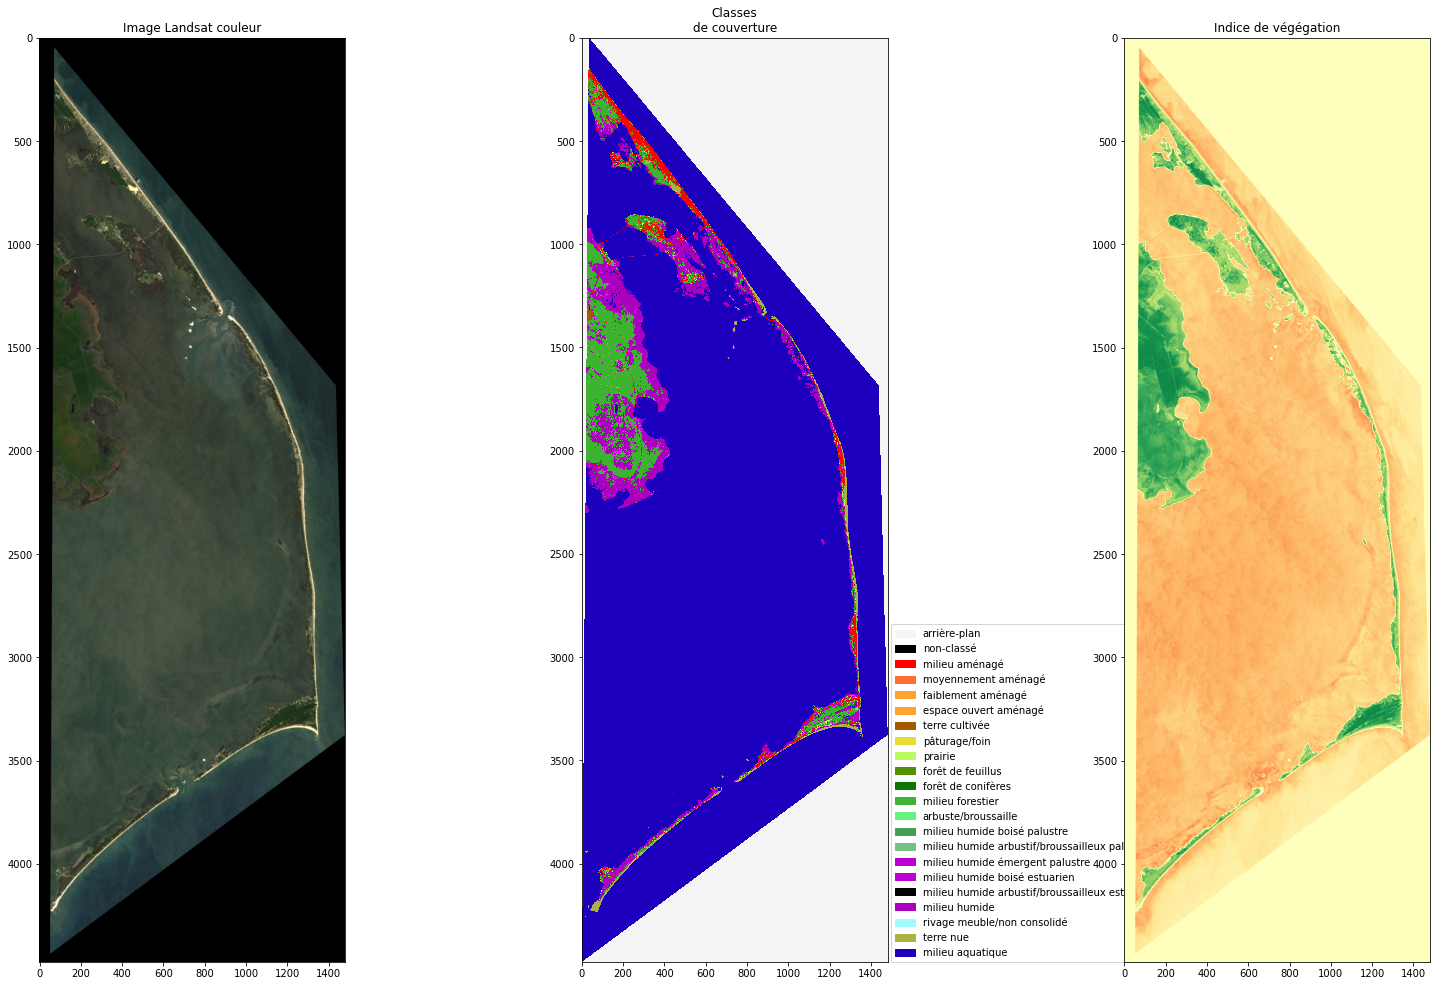

In [19]:
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show

# pull out the bands we want to visualize
index = np.array([3, 2, 1])
colors = images_landsat[index, :, :].astype(np.float64)

# we'll use the values to stretch the landsat image based on the above histogram
max_val = 2500
min_val = 0

# enforce maximum and minimum values
colors[colors[:, :, :] > max_val] = max_val
colors[colors[:, :, :] < min_val] = min_val

for b in range(colors.shape[0]):
    colors[b, :, :] = colors[b, :, :] * 1 / (max_val - min_val)

# rasters are in the format [bands, rows, cols] 
# whereas images are typically [rows, cols, bands]
# and so our array needs to be reshaped
print(colors.shape)
colors_reshaped = reshape_as_image(colors)
print(colors_reshaped.shape)

# next setup a colormap for our map
fausses_couleurs = dict((
    (0, (245,245,245, 255)), # arrière-plan # Background
    (1, (0,0,0)), # non-classé # Unclassified (Cloud, Shadow, etc)
    (2, (255,0,0)), # fortement aménagé # High Intensity Developed
    (3, (255, 110, 51)), # moyennement aménagé # Medium Intensity Developed
    (4, (255, 162, 51)), # faiblement aménagé # Low Intensity Developed
    (5, (255, 162, 51)), # espace ouvert aménagé # Open Space Developed
    (6, (162, 89, 0)), # terre cultivée # Cultivated Land
    (7, (229, 221, 50)), # pâturage/foin # Pasture/Hay
    (8, (185, 251, 96)), # prairie # Grassland
    (9, (83, 144, 0)), # forêt de feuillus # Deciduous Forest
    (10, (13, 118, 0  )), # forêt de conifères # Evergreen Forest
    (11, (62, 178, 49)), # forêt mixte / Mixed Forest
    (12, (100, 241, 125)), # arbuste/broussaille # Scrub/Shrub
    (13, (68, 160, 85)), # milieu humide boisé palustre # Palustrine Forested Wetland
    (14, (118, 192, 131)), # milieu humide arbustif/broussailleux palustre # Palustrine Scrub/Shrub Wetland
    (15, (188, 0, 211)), # milieu humide émergent palustre # Palustrine Emergent Wetland
    (16, (188, 0, 211)), # milieu humide boisé estuarien # Estuarine Forested Wetland
    (17, (0, 0, 0)), # milieu humide arbustif/broussailleux estuarien # Estuarine Scrub/Shrub Wetland
    (18, (172, 0, 191)), # milieu humide émergent estuarien # Estuarine Emergent Wetland
    (19, (159, 251, 255)), # rivage meuble/non consolidé # Unconsolidated Shore 
    (20, (172, 177, 68)), # terre nue # Bare Land
    (21, (29, 0, 189)), # eau # Water
    (22, (40, 40, 40)), # lit de cours d'eau palustre # Pal Bed
))

# n = int(np.max(jeu_etiquettes_couverture)) + 1
n = int(np.max(etiquettes_couverture)) + 1

# Put 0 - 255 as float 0 - 1
for k in fausses_couleurs:
    v = fausses_couleurs[k]
    _v = [_v / 255.0 for _v in v]
    fausses_couleurs[k] = _v
    
index_fausses_couleurs = [fausses_couleurs[key] for key in range(0, n)]

cmap_fausses_couleurs = plt.matplotlib.colors.ListedColormap(index_fausses_couleurs, 
                                                             'Classification', 
                                                             n)
fig, axes = plt.subplots(1, 3, figsize=(1.62*17, 17)) 

# Afficher l'image en couleur
axes[0].imshow(colors_reshaped)
axes[0].set_title('Image Landsat couleur')

# Afficher les classes de couverture en fausses couleurs
axes[1].imshow(etiquettes_couverture[0,:, :],
               cmap=cmap_fausses_couleurs,
               interpolation='none')
import matplotlib.patches as mpatches
patches =[mpatches.Patch(color=cmap_fausses_couleurs.colors[classe_id],label=classes_couverture[classe_id]) 
          for classe_id in range(len(cmap_fausses_couleurs.colors))]
axes[1].set_title('Classes\nde couverture')
axes[1].legend(handles=patches, loc=(1.01,0), borderaxespad=0.)

# Afficher l'indice de végétation
axes[2].imshow(indice_vegetation, 
              cmap='RdYlGn')
axes[2].set_title('Indice de végégation')

# Afficher les images
plt.show()


In [20]:
cmap_fausses_couleurs.colors[0]

[0.9607843137254902, 0.9607843137254902, 0.9607843137254902, 1.0]

Combien y a-t-il de pixels dans chaque classe ?

In [21]:
unique, counts = np.unique(etiquettes_couverture, return_counts=True)
hist_data = [(classes_couverture[classe_id],counts) for classe_id,counts in list(zip(unique, counts))]
hist_data

[('arrière-plan', 2189505),
 ('milieu aménagé', 53319),
 ('terre cultivée', 15131),
 ('prairie', 6340),
 ('milieu forestier', 233678),
 ('milieu humide', 272903),
 ('terre nue', 40077),
 ('milieu aquatique', 3822479)]

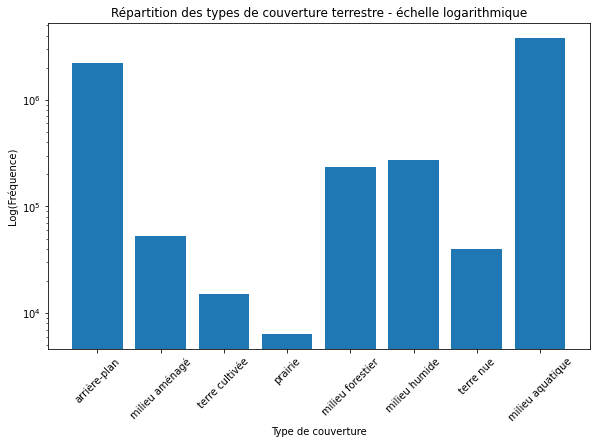

In [72]:
fig = plt.figure(figsize=(1.62*6, 6)) 
plt.yscale('log')
plt.xticks(rotation=45)
plt.xlabel("Type de couverture")
plt.ylabel("Log(Fréquence)")
plt.title("Répartition des types de couverture terrestre - échelle logarithmique")
_ = plt.bar([classe[0] for classe in hist_data], [classe[1] for classe in hist_data])


### Génération des données d'entraînement

In [23]:
# Le code ci-dessous génère des avertissements
# nous allons donc les supprimer pour le moment 
import warnings
warnings.filterwarnings("ignore")

In [24]:
pixels_entrainement = generer_pixels([meta_donnees_images_landsat],
                                     meta_donnees_etiquettes_couverture,
                                     etiquettes_couverture,
                                     classes_couverture,
                                     3000,
                                     True)


train_count_per_dataset: 3000
len(liste_jeux_donnees_images): 1
points_per_class: 375
raster_points: ((1792875.0, 1650645.0), (1837305.0, 1650645.0), (1837305.0, 1516395.0), (1792875.0, 1516395.0))


Traitement de la classe-cible « milieu aquatique »: 100%|██████████| 8/8 [01:07<00:00,  8.48s/it]


### Test du générateur de tuiles

Afficher des lots d'images et d'étiquettes et vérifier leurs dimensions.

In [77]:
im_batch = None

count = 0

for (im, label) in generer_tuiles([meta_donnees_images_landsat], 
                                  meta_donnees_etiquettes_couverture, 
                                  classes_couverture,
                                  128, 128, 
                                  pixels_entrainement, 
                                  10):
    # Arrêter après 3 images 
    if count > 3:
        break
    print('Image')
    print(im.shape)
#     for index_lot in range(10):
#         for canal in range(7):
#             plt.imshow((normalize(im[index_lot,:,:,canal])))
#             plt.show()
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----
Image
(10, 128, 128, 7)
Label
(10, 26)
----


### Visualisation de tuiles

Maintenant, visualisons des tuiles réelles. 

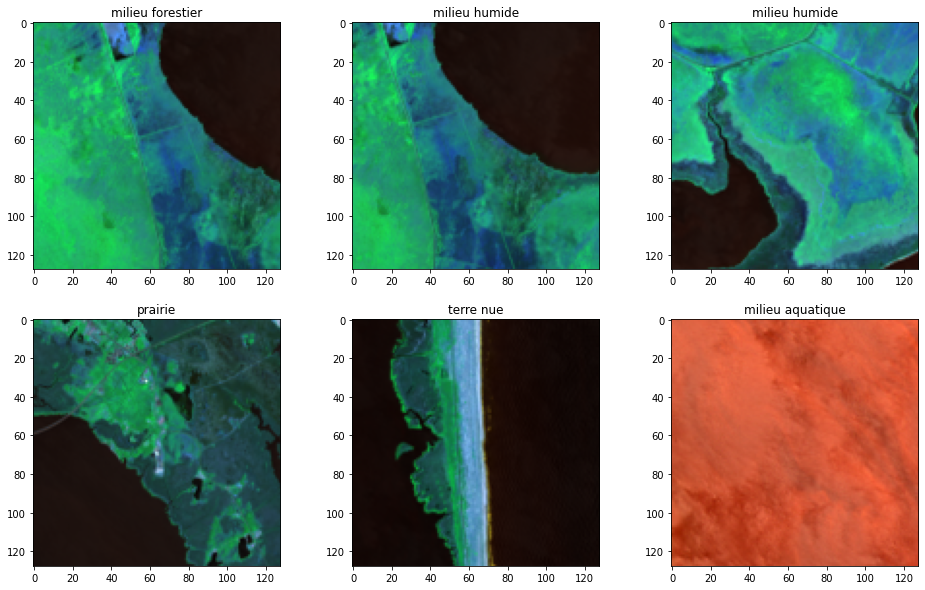

In [78]:
import numpy as np

def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

fig, axes = plt.subplots(2, 3, figsize=(1.62*10, 10)) 
axes[0,0].imshow(normalize(im_batch[0,:,:,3:6]))
axes[0,0].set_title(classes_couverture[np.argmax(label_batch[0])])
axes[0,1].imshow(normalize(im_batch[1,:,:,3:6]))
axes[0,1].set_title(classes_couverture[np.argmax(label_batch[1])])
axes[0,2].imshow(normalize(im_batch[2,:,:,3:6]))
axes[0,2].set_title(classes_couverture[np.argmax(label_batch[2])])
axes[1,0].imshow(normalize(im_batch[3,:,:,3:6]))
axes[1,0].set_title(classes_couverture[np.argmax(label_batch[3])])
axes[1,1].imshow(normalize(im_batch[4,:,:,3:6]))
axes[1,1].set_title(classes_couverture[np.argmax(label_batch[4])])
axes[1,2].imshow(normalize(im_batch[5,:,:,3:6]))
axes[1,2].set_title(classes_couverture[np.argmax(label_batch[5])])

plt.show()


### Générer un jeu de données d'entraînement de tuiles 1x1 pour scikit-learn 


In [79]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
    
for (im, label) in generer_tuiles([meta_donnees_images_landsat], 
                                  meta_donnees_etiquettes_couverture, 
                                  classes_couverture, 
                                  1, 1, 
                                  pixels_entrainement, 
                                  sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 26)
----


#### Reformater les données
Reformater les donnés pour scikit-learn qui a besoin de données au format `(echantillons, bandes)` :

In [80]:
im_batch[0,:,:,:]

array([[[-0.45, -0.34, -0.15, -0.19, -0.65, -0.73, -0.77]]])

In [81]:
im_batch_reshaped = im_batch.reshape(sample_size,7)
im_batch_reshaped[0]

array([-0.45, -0.34, -0.15, -0.19, -0.65, -0.73, -0.77])

### Visualiser les signatures spectrales

Examinons le spectre des intensités pour les différentes bandes ou canaux. Rappelons que la réflectance est le rapport de l'intensité d'une onde réfléchie sur l'intensité de l'onde incidente. 

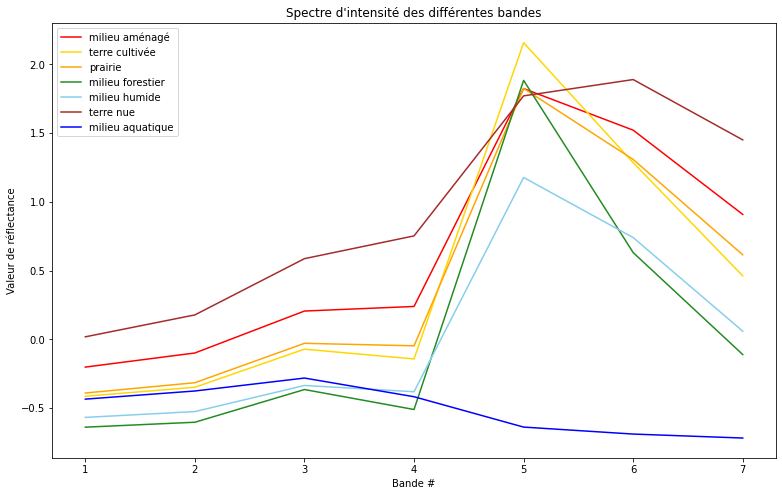

In [84]:
fig, axe = plt.subplots(1,1, figsize=[1.62*8,8])

liste_couleurs = ['red', # 'milieu aménagé' 2
                  'gold', # 'terre cultivée' 6
                  'orange', # 'prairie' 8
                  'forestgreen', # 'milieu forestier' 11
                  'skyblue', # 'milieu humide' 18
                  'brown', # 'terre nue' 20
                  'blue'] # eau 21

# numbers 1-8
band_count = np.arange(1,8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for index_couleur,class_type in enumerate(classes): 
    band_intensity = np.mean(X[y==class_type, :], axis=0)
    axe.plot(band_count, 
             band_intensity, 
             color=liste_couleurs[index_couleur], 
             label=classes_couverture[class_type])
# plot them as lines

# Add some axis labels
axe.set_xlabel('Bande #')
axe.set_ylabel('Valeur de réflectance')

# Add a title
axe.set_title("Spectre d'intensité des différentes bandes")
_ = axe.legend(loc='upper left')

## Création d'une base de référence pour la classification 

### Générer un ensemble de données d'entraînement de tuiles 1x1 pour scikit-learn

In [85]:
im_batch = None
label_batch = None

sample_size = 800
train_count = 600

count = 0
    
for (img, label) in generer_tuiles([meta_donnees_images_landsat], 
                                  meta_donnees_etiquettes_couverture,
                                  classes_couverture,
                                  1, 1, 
                                  pixels_entrainement, 
                                  sample_size):
    if count > 0:
        break
    print('Batch Shape')
    print(img.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    img_batch = img
    label_batch = label

img_batch_reshaped = img_batch.reshape(sample_size,7)

X_train = img_batch_reshaped[:train_count]
X_val = img_batch_reshaped[train_count:]
y_train = np.argmax(label_batch, axis=1)[:train_count]
y_val = np.argmax(label_batch, axis=1)[train_count:]

Batch Shape
(800, 1, 1, 7)
Label Shape
(800, 26)
----


### Algorithme de la forêt aléatoire (<i>random forest</i>)

In [86]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, 
                            oob_score=True)

# Fit our model to training data
rf = rf.fit(X_train, y_train)

print('Exactitude de: {accuracy:.2f}%'.format(accuracy = rf.score(X_val, y_val)*100))

Exactitude de: 56.50%


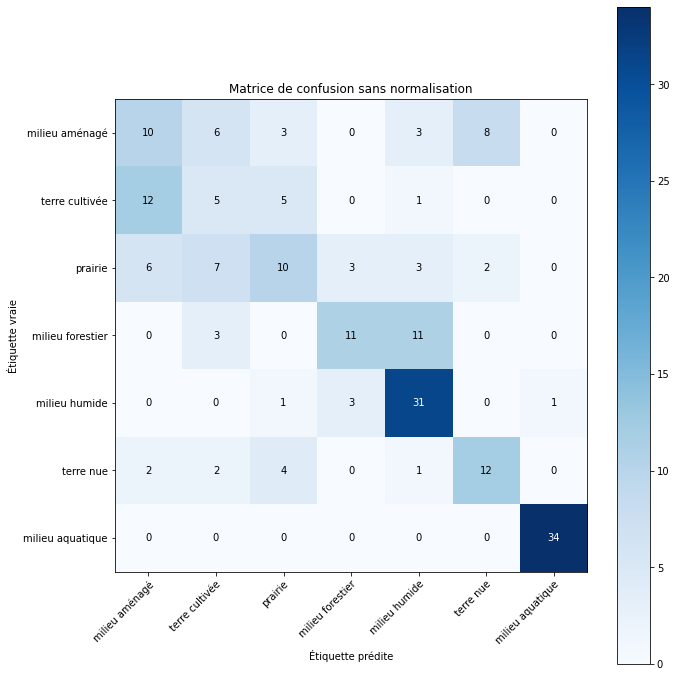

In [87]:
pred_index = rf.predict(X_val)

# Plot non-normalized confusion matrix
_ = afficher_matrice_confusion(y_val,
                               pred_index,
                               classes=np.array(list(classes_couverture)),
                               class_dict=classes_couverture)


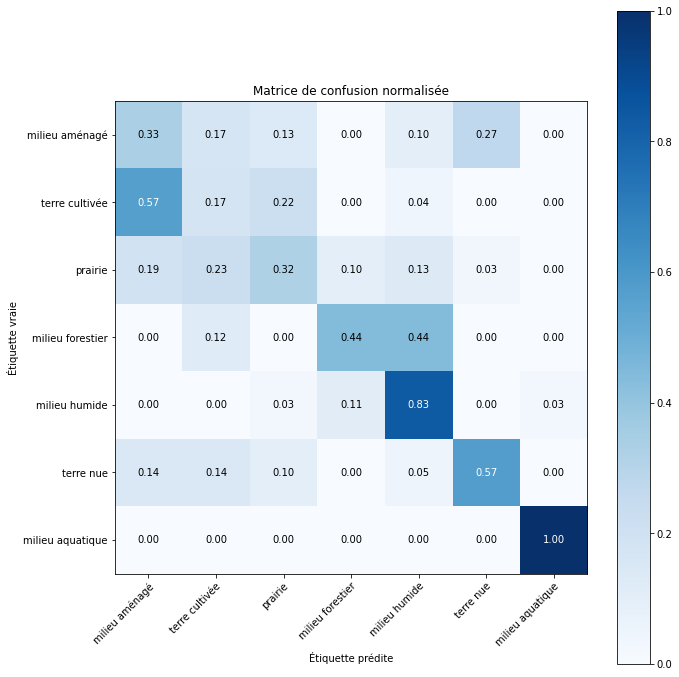

In [43]:
# Plot normalized confusion matrix
_ = afficher_matrice_confusion(y_val,
                               pred_index,
                               classes=np.array(list(classes_couverture)),
                               class_dict=classes_couverture,
                               normalize=True)


In [44]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Exactitude: {exactitude:.2f}%".format(exactitude = accuracy_score(y_val, pred_index)*100)) 
print("Précision: {precision:.2f}%".format(precision = precision_score(y_val, pred_index, average='weighted')*100))
print("Rappel: {rappel:.2f}%".format(rappel = recall_score(y_val, pred_index, average='weighted')*100))
print("Métrique F1: {f1:.2f}%".format(f1 = f1_score(y_val, pred_index, average='weighted')*100))


Exactitude: 55.50%
Précision: 54.78%
Rappel: 55.50%
Métrique F1: 54.44%


Ces modèles ne sont pas terribles mais ils classent mal une bonne partie des prairies, des terres cultivées et des terres anthropoformées. Voyons si nous pouvons l'améliorer !

## Création et entraînement d'un réseau convolutif

### Importer les bibliothèques `keras` nécessaires

In [45]:
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

### Définir les hyperparamètres du résau convolutif

In [46]:
batch_size = 25
epochs = 25
num_classes = len(classes_couverture)

# input image dimensions
tile_side = 32
img_rows, img_cols = tile_side, tile_side
img_bands = meta_donnees_images_landsat.count- 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


### Créer l'architecture du réseau convolutif

In [47]:
modele = Sequential()

modele.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(MaxPooling2D(pool_size=(2, 2)))

modele.add(Conv2D(64, (3, 3), padding='same'))
modele.add(BatchNormalization())
modele.add(Activation('relu'))

modele.add(Conv2D(64, (3, 3), padding='same'))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(MaxPooling2D(pool_size=(2, 2)))

modele.add(Conv2D(128, (3, 3), padding='same'))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(MaxPooling2D(pool_size=(2, 2)))

modele.add(Conv2D(256, (3, 3), padding='same'))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(MaxPooling2D(pool_size=(2, 2)))
modele.add(Dropout(0.25))

modele.add(Flatten())
modele.add(Dense(128))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(Dropout(0.25))

modele.add(Dense(128))
modele.add(BatchNormalization())
modele.add(Activation('relu'))
modele.add(Dropout(0.25))

modele.add(Dense(num_classes))
modele.add(Activation('softmax'))

modele.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 64)        0

### Choisir la fonction d'optimisation et compiler le modèle

In [48]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, 
                              decay=1e-6, 
                              momentum=0.9, 
                              nesterov=True)
metrics=['accuracy']

modele.compile(optimizer=sgd, 
               loss='categorical_crossentropy', 
               metrics=metrics)

print("Modèle compilé")

Modèle compilé


### Diviser les données entre donnés d'entraînement et données de validation

In [88]:
train_to_val_ratio = 0.8
train_px = pixels_entrainement[:int(len(pixels_entrainement)*train_to_val_ratio)]
val_px = pixels_entrainement[int(len(pixels_entrainement)*train_to_val_ratio):]
print("Nombre d'exemples d'entraînement: {n_entrainement} \nNombre d'exemples de validation: {n_validation}".
      format(n_entrainement=len(train_px),n_validation=len(val_px)))

Nombre d'exemples d'entraînement: 2400 
Nombre d'exemples de validation: 600


### Entraîner le modèle

In [50]:
traces = modele.fit(generer_tuiles([meta_donnees_images_landsat], 
                                   meta_donnees_etiquettes_couverture, 
                                   classes_couverture,
                                   tile_side, 
                                   tile_side, 
                                   train_px, 
                                   batch_size, 
                                   merge=True), 
                    steps_per_epoch=len(train_px) // batch_size, 
                    epochs=epochs, 
                    verbose=1,
                    validation_data=generer_tuiles([meta_donnees_images_landsat], 
                                                   meta_donnees_etiquettes_couverture, 
                                                   classes_couverture,
                                                   tile_side, 
                                                   tile_side, 
                                                   val_px, 
                                                   batch_size, 
                                                   merge=True),
                    validation_steps=len(val_px) // batch_size)



Epoch 1/25
96/96 [==============================] - 36s 356ms/step - loss: 2.9839 - accuracy: 0.1971 - val_loss: 3.1160 - val_accuracy: 0.3400
Epoch 2/25
96/96 [==============================] - 32s 340ms/step - loss: 2.3090 - accuracy: 0.3979 - val_loss: 2.6304 - val_accuracy: 0.3717
Epoch 3/25
96/96 [==============================] - 31s 324ms/step - loss: 1.9675 - accuracy: 0.4663 - val_loss: 2.0728 - val_accuracy: 0.4833
Epoch 4/25
96/96 [==============================] - 34s 357ms/step - loss: 1.7687 - accuracy: 0.5133 - val_loss: 1.7273 - val_accuracy: 0.5400
Epoch 5/25
96/96 [==============================] - 39s 409ms/step - loss: 1.6091 - accuracy: 0.5479 - val_loss: 1.5187 - val_accuracy: 0.5600
Epoch 6/25
96/96 [==============================] - 35s 363ms/step - loss: 1.4923 - accuracy: 0.5746 - val_loss: 1.4125 - val_accuracy: 0.5667
Epoch 7/25
96/96 [==============================] - 46s 481ms/step - loss: 1.4230 - accuracy: 0.5700 - val_loss: 1.3533 - val_accuracy: 0.5767

### Affichage des courbes d'entraînement et de validation

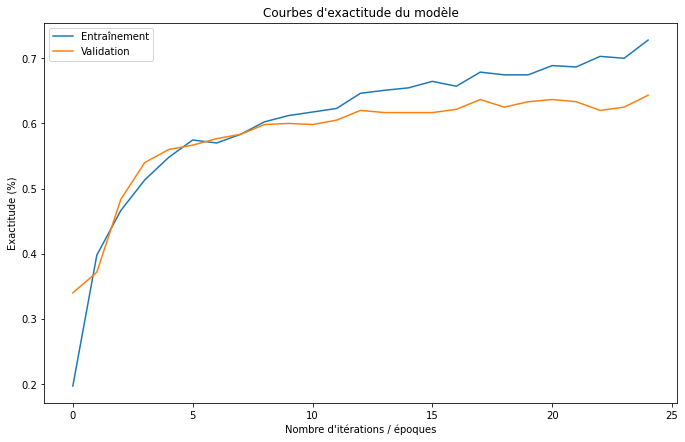

In [59]:
plt.figure(figsize=(1.62*7,7))
plt.plot(traces.history['accuracy'])
plt.plot(traces.history['val_accuracy'])
plt.title("Courbes d'exactitude du modèle")
plt.ylabel("Exactitude (%)")
plt.xlabel("Nombre d'itérations / époques")
_ = plt.legend(['Entraînement', 'Validation'], loc='upper left')

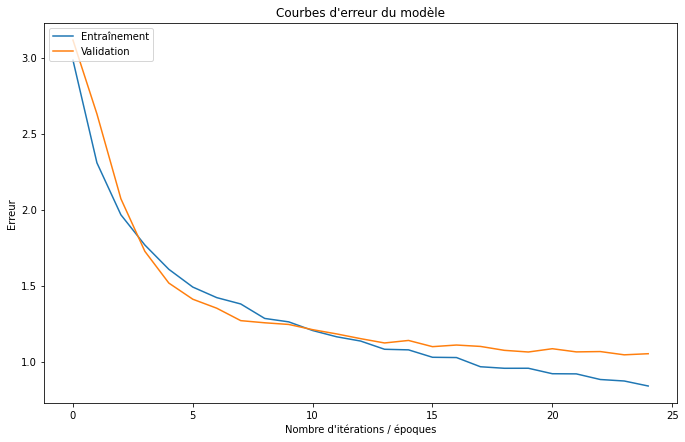

In [60]:
plt.figure(figsize=(1.62*7,7))
plt.plot(traces.history['loss'])
plt.plot(traces.history['val_loss'])
plt.title("Courbes d'erreur du modèle")
plt.ylabel("Erreur")
plt.xlabel("Nombre d'itérations / époques")
_ = plt.legend(['Entraînement', 'Validation'], loc='upper left')

### Génération de données test

In [53]:
predictions = modele.predict(generer_tuiles([meta_donnees_images_landsat],
                                            meta_donnees_etiquettes_couverture,
                                            classes_couverture,
                                            tile_side,
                                            tile_side,
                                            val_px,
                                            batch_size,
                                            merge=True),
                             steps=len(val_px) // batch_size,
                             verbose=1)

eval_generator = generer_tuiles([meta_donnees_images_landsat], 
                                meta_donnees_etiquettes_couverture,
                                classes_couverture,
                                tile_side, 
                                tile_side, 
                                val_px, 
                                1, 
                                merge=True)

labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

24/24 [==============================] - 7s 271ms/step


###  Affichage d'une matrice de confusion :

In [54]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

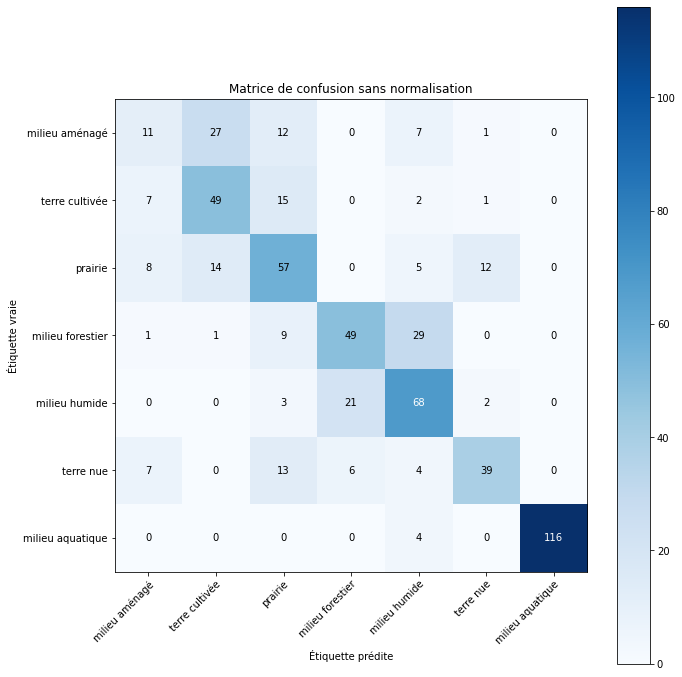

In [55]:
# Plot non-normalized confusion matrix
_ = afficher_matrice_confusion(label_index,
                               pred_index,
                               classes=np.array(list(classes_couverture)),
                               class_dict=classes_couverture)


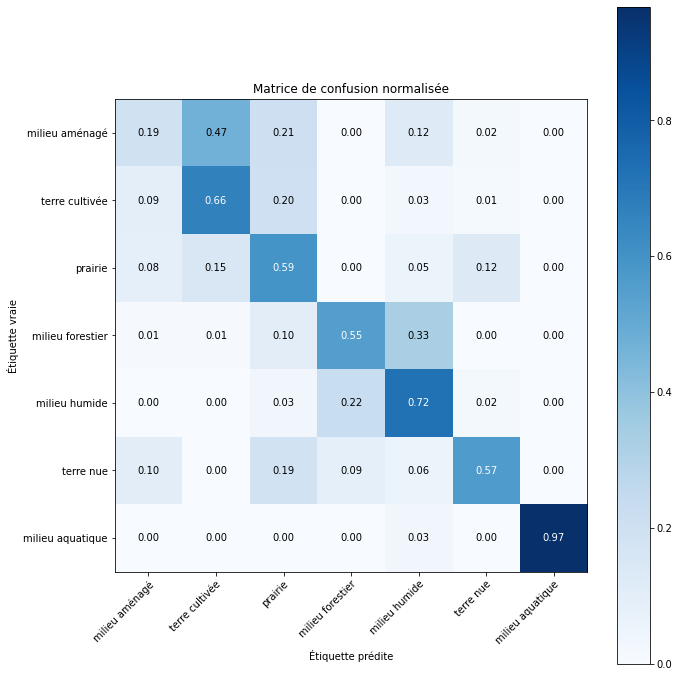

In [56]:
# Plot normalized confusion matrix
_ = afficher_matrice_confusion(label_index, 
                               pred_index,
                               classes=np.array(list(classes_couverture)),
                               class_dict=classes_couverture,
                               normalize=True)


In [57]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
print("Exactitude: {exactitude:.2f}%".format(exactitude = accuracy_score(label_index, pred_index)*100)) 
print("Précision: {precision:.2f}%".format(precision = precision_score(label_index, pred_index, average='weighted')*100))
print("Rappel: {rappel:.2f}%".format(rappel = recall_score(label_index, pred_index, average='weighted')*100))
print("Métrique F1: {f1:.2f}%".format(f1 = f1_score(label_index, pred_index, average='weighted')*100))


Exactitude: 64.83%
Précision: 64.81%
Rappel: 64.83%
Métrique F1: 64.24%


Pas mal! Environ 10 % d'amélioration pour un réseau convolutif par rapport à un algorithme d'apprentissage automatique plus classique.

## Conclusion

Vous avez expérimenté avec un certain nombre de techniques d'exploration de données satellitaires et vu comment utiliser Keras pour construire un réseau convolutif profond pour une classification efficace de la couverture terrestre. 

In [90]:
print("Exécution du carnet web IPython terminée")

Exécution du carnet web IPython terminée
